# W266 Final Project - Amazon Reviews

This notebook is to read in the cleaned data and work with the data in keras.

http://jmcauley.ucsd.edu/data/amazon/links.html

In [1]:
import pandas as pd
import gzip
import random
from collections import defaultdict
import seaborn as sns
import numpy as np
import re

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding

import tensorflow_hub as hub
import tensorflow as tf

/home/lance_miles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
W0326 20:49:25.892610 140226342946624 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [2]:
files = ['reviews_Video_Games.json.gz', 
         'reviews_Toys_and_Games.json.gz', 
         'reviews_Sports_and_Outdoors.json.gz', 
         'reviews_Movies_and_TV.json.gz',
         'reviews_Kindle_Store.json.gz', 
         'reviews_Home_and_Kitchen.json.gz',
         'reviews_Health_and_Personal_Care.json.gz', 
         'reviews_Electronics.json.gz',
         'reviews_Clothing_Shoes_and_Jewelry.json.gz',
         'reviews_Cell_Phones_and_Accessories.json.gz', 
         'reviews_CDs_and_Vinyl.json.gz',
         'reviews_Books.json.gz']
filesNames = ['reviews_Video_Games', 
              'reviews_Toys_and_Games',
              'reviews_Sports_and_Outdoors', 
              'reviews_Movies_and_TV',
              'reviews_Kindle_Store', 
              'reviews_Home_and_Kitchen',
              'reviews_Health_and_Personal_Care', 
              'reviews_Electronics',
              'reviews_Clothing_Shoes_and_Jewelry',
              'reviews_Cell_Phones_and_Accessories', 
              'reviews_CDs_and_Vinyl',
              'reviews_Books']

def dataFullSets(original, concatData, name):
    currentData = original
    appendData = pd.read_csv('../Data/%s'%(concatData))
    appendData['Product'] = name
    newDF = pd.concat([currentData,appendData])
    return(newDF)

train_data = pd.read_csv('../Data/%s_train.csv'%(filesNames[0]))
train_data['Product'] = filesNames[0]
test_data = pd.read_csv('../Data/%s_test.csv'%(filesNames[0]))
test_data['Product'] = filesNames[0]
                        
for fileName in filesNames[1:]:
    concatName_train = str(fileName+'_train.csv')
    concatName_test = fileName+'_test.csv'
                        
    train_data = dataFullSets(train_data, concatName_train, fileName).sample(frac=1)
    test_data = dataFullSets(test_data, concatName_test, fileName).sample(frac=1)

/home/lance_miles/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



In [3]:
train_data.head()

,Product,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,sentiment,summary,unixReviewTime
24896,reviews_Movies_and_TV,B007C2DRDG,"[2, 5]",5.0,Leonard Cohen is a legend - one of a kind! Ins...,"06 1, 2013",A1BLT75VT39UKU,Shirley Kussner,1,Insight to his life,1370044800
22250,reviews_Movies_and_TV,B00CYOVV0I,"[1, 1]",1.0,"Horible bad bad and bad , the only thing that ...","01 4, 2014",AH6S1X0OG7SOA,David J Daye,0,Great produts,1388793600
29087,reviews_Sports_and_Outdoors,B007VG761C,"[0, 0]",5.0,I leave for work at 4am and this mug keeps my ...,"03 28, 2014",A2GYU5RG93TVGG,Big Kyle 570,1,"Finally, a great travel mug!",1395964800
27530,reviews_Health_and_Personal_Care,B000KPDW3C,"[0, 0]",5.0,I bought one of these for myself. I love it so...,"08 16, 2013",AV6FO4YZMFEBI,"Elizabeth A. Tool ""LIZZYGOAT""",1,ONE FOR ME ONE FOR MY SISTER,1376611200
16026,reviews_Sports_and_Outdoors,B002PB2HPS,"[9, 12]",1.0,I bought this tent from walmart 3 years ago. ...,"08 8, 2013",A1Y1F0FKLQWETM,"Amanda Eckelbecker ""getalife""",0,VERY Disapointed,1375920000


In [4]:
test_data.head()

,Product,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,sentiment,summary,unixReviewTime
15953,reviews_Sports_and_Outdoors,B000G2Z4W6,"[0, 0]",5.0,The package got divided between our bug out ba...,"05 30, 2013",A7DK4J73J3ET2,Michael H. Howell,1,Bug out bag,1369872000
15823,reviews_Health_and_Personal_Care,B001ADL1SG,"[0, 0]",1.0,I bought this about a year ago. I like the ou...,"12 29, 2013",AB70TXTFI1FJ9,Jen,0,Great product if you don't mind SLIME,1388275200
2633,reviews_Electronics,B000069E1H,"[3, 18]",1.0,Bose unfortunately provides little support. It...,"12 30, 2010",ANH0HXCEU8O45,Manoj,0,A big struggle to find the suitable cable to c...,1293667200
6247,reviews_Clothing_Shoes_and_Jewelry,B00567E3O6,"[0, 0]",1.0,I recieved the watch and it say that is Water ...,"05 2, 2013",AURW2OM0PQW4O,Jose Luis,0,Water prooff???,1367452800
7372,reviews_Health_and_Personal_Care,B0013NE108,"[5, 5]",5.0,"Relieved the redness & itchy eyes, much better...","02 4, 2009",A1R4NNIIREOMC5,"George Daney ""daneish""",1,Nature's Tears Eye Mist.,1233705600


In [5]:
#practice sentence
test_sentence = test_data['reviewText'].iloc[19]
test_sentence

"There's nothing much to say about this product. I hooked it i hooked it up between my deck and my amp and my amp and it COMPLETELY eliminated the the whining noise.. I would recommend this product to anyone. It's cheap and it works!!!"

In [6]:
#prepare reviews to be split by words
#change to lowercase, remove punctuation and numbers
test_data_word_prep = re.sub("[^a-zA-Z]", " ", test_sentence).lower()
test_data_word_prep

'there s nothing much to say about this product  i hooked it i hooked it up between my deck and my amp and my amp and it completely eliminated the the whining noise   i would recommend this product to anyone  it s cheap and it works   '

In [7]:
#list of words after processing
test_data_word_prep.strip().split()

['there',
 's',
 'nothing',
 'much',
 'to',
 'say',
 'about',
 'this',
 'product',
 'i',
 'hooked',
 'it',
 'i',
 'hooked',
 'it',
 'up',
 'between',
 'my',
 'deck',
 'and',
 'my',
 'amp',
 'and',
 'my',
 'amp',
 'and',
 'it',
 'completely',
 'eliminated',
 'the',
 'the',
 'whining',
 'noise',
 'i',
 'would',
 'recommend',
 'this',
 'product',
 'to',
 'anyone',
 'it',
 's',
 'cheap',
 'and',
 'it',
 'works']

In [8]:
#prepare reviews to be split by sentences
#change to lowercase, changes (!?) to (.), removes numbers, allows to be split by periods
test_data_sent_prep = re.sub("[!?]", ".", test_sentence)
test_data_sent_prep = re.sub("[^a-zA-Z.]", " ", test_data_sent_prep).lower()
test_data_sent_prep

'there s nothing much to say about this product. i hooked it i hooked it up between my deck and my amp and my amp and it completely eliminated the the whining noise.. i would recommend this product to anyone. it s cheap and it works...'

In [9]:
#list of sentences after processing
[sent.strip(" ") for sent in test_data_sent_prep.split('.')]

['there s nothing much to say about this product',
 'i hooked it i hooked it up between my deck and my amp and my amp and it completely eliminated the the whining noise',
 '',
 'i would recommend this product to anyone',
 'it s cheap and it works',
 '',
 '',
 '']

In [10]:
play_data = test_data[:10]
#print(play_data)

#function to process review text and split into words
def splitWords(data):
    data_prep = str(data['reviewText'])
    data_prep = re.sub("[^a-zA-Z]", " ", data_prep).lower()
    return data_prep.split()

#function to process review text and split into sentences
def splitSentences(data):
    data_prep = str(data['reviewText'])
    data_prep = re.sub("[!?]", ".", data_prep)
    data_prep = re.sub("[^a-zA-Z.]", " ", data_prep).lower().split('.')
    data_prep = [sentence.strip(" ") for sentence in data_prep]
    return data_prep


#list of words from review into column
sentences = play_data.apply(splitWords, axis=1)
play_data.insert(loc = 11, column = 'sentenceWords', value = sentences)

sentences = train_data.apply(splitWords, axis=1)
train_data.insert(loc = 11,column = 'sentenceWords', value = sentences)

sentences = test_data.apply(splitWords, axis=1)
test_data.insert(loc = 11,column = 'sentenceWords', value = sentences)


#list of sentences from review into column
sentences_split = play_data.apply(splitSentences, axis=1)
play_data.insert(loc = 12, column = 'sentences', value = sentences_split)

sentences_split = train_data.apply(splitSentences, axis=1)
train_data.insert(loc = 12,column = 'sentences', value = sentences_split)

sentences_split = test_data.apply(splitSentences, axis=1)
test_data.insert(loc = 12,column = 'sentences', value = sentences_split)

In [11]:
wordFreq = defaultdict(int)

wordData = train_data['sentenceWords']

for row in wordData:
    for word in row:
        wordFreq[word] += 1      

In [12]:
wordsForHist = list(wordFreq.values())

/home/lance_miles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Word Frequency for Train Data')

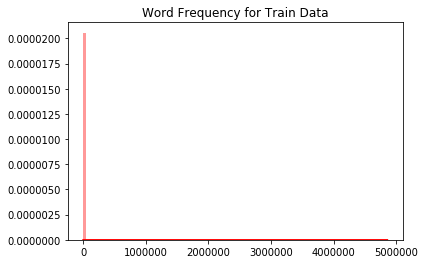

In [13]:
sns.distplot(wordsForHist, bins=100, color = 'red').set_title('Word Frequency for Train Data')

In [14]:
reviewLength = []

for row in wordData:
    reviewLength.append(len(row))

/home/lance_miles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Sentence Lengths for Train Data')

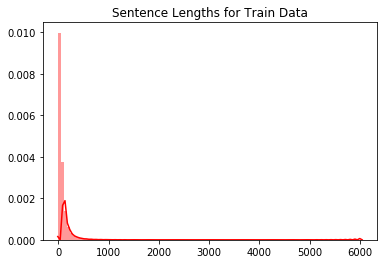

In [15]:
sns.distplot(reviewLength, bins=100, color = 'red').set_title('Sentence Lengths for Train Data')

In [16]:
print('Mean:',np.mean(reviewLength))
print('Median:',np.median(reviewLength))

Mean: 81.19317833333334
Median: 47.0


## Universal Sentence Encoder

In [17]:
embedding = hub.Module("https://tfhub.dev/google/universal-sentence-encoder-large/3")

In [18]:
test_par = [(play_data['reviewText'].iloc[0])]
test_par

['The package got divided between our bug out bags so we will be sure to have fire no matter what.']

In [19]:
#supress messages
tf.logging.set_verbosity(tf.logging.ERROR)

with tf.Session() as sess:
    sess.run([tf.global_variables_initializer(), tf.tables_initializer()])
    review_embeddings = sess.run(embedding((test_par)))
    
review_embeddings = np.array(review_embeddings)
review_embeddings.shape

(1, 512)

In [20]:
review_embeddings

array([[-3.20151299e-02,  2.32956130e-02,  4.79711778e-02,
         4.53879535e-02, -3.46658565e-02,  3.61542702e-02,
         6.92478288e-03, -4.09053825e-02, -2.83886380e-02,
        -3.16946618e-02,  8.40265825e-02, -1.78929362e-02,
        -6.94046319e-02,  3.03007010e-02,  2.26936825e-02,
        -1.61600970e-02,  1.17623061e-01,  5.02063036e-02,
         5.87594211e-02,  6.66756779e-02,  1.99708641e-02,
         3.69834267e-02, -5.26656657e-02,  3.39785889e-02,
        -2.49138102e-02,  8.71205796e-03,  1.45552373e-02,
         8.02025758e-03, -4.93671820e-02, -4.45176214e-02,
        -8.38828757e-02, -3.46864313e-02, -3.93720716e-02,
        -2.99540479e-05, -1.14692915e-02,  3.65693644e-02,
         2.44814549e-02,  8.69069342e-03,  2.04131026e-02,
         5.22214659e-02, -3.31851989e-02, -4.96946387e-02,
        -1.44161666e-02,  4.50265855e-02,  1.42728211e-02,
         9.96453315e-03,  4.93760221e-02,  7.97868986e-03,
        -5.26542496e-03, -4.46357131e-02, -8.84217098e-0

## Keras

In [27]:
embed_size   = 300   # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen       = 1000   # max number of words in a comment to use 

list_sentences_train = list(play_data['reviewText'])

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
#list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

#list_tokenized_train

X_train = pad_sequences(list_tokenized_train, maxlen=maxlen, padding='post')

X_train.shape

(10, 1000)

In [ ]:
#https://machinelearningmastery.com/develop-n-gram-multichannel-convolutional-neural-network-sentiment-analysis/
# define the model
def define_model(length, vocab_size):
    # channel 1
    inputs1 = Input(shape=(length,))
    embedding1 = Embedding(vocab_size, 100)(inputs1)
    conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    # channel 2
    inputs2 = Input(shape=(length,))
    embedding2 = Embedding(vocab_size, 100)(inputs2)
    conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    # channel 3
    inputs3 = Input(shape=(length,))
    embedding3 = Embedding(vocab_size, 100)(inputs3)
    conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
    # merge
    merged = concatenate([flat1, flat2, flat3])
    # interpretation
    dense1 = Dense(10, activation='relu')(merged)
    outputs = Dense(1, activation='sigmoid')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    # compile
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # summarize
    print(model.summary())
    plot_model(model, show_shapes=True, to_file='multichannel.png')
    return model

In [ ]:
#https://machinelearningmastery.com/develop-n-gram-multichannel-convolutional-neural-network-sentiment-analysis/

from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
 
# load a clean dataset
def load_dataset(filename):
    return load(open(filename, 'rb'))
 
# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer
 
# calculate the maximum document length
def max_length(lines):
    return max([len(s.split()) for s in lines])
 
# encode a list of lines
def encode_text(tokenizer, lines, length):
    # integer encode
    encoded = tokenizer.texts_to_sequences(lines)
    # pad encoded sequences
    padded = pad_sequences(encoded, maxlen=length, padding='post')
    return padded
 
# define the model
def define_model(length, vocab_size):
    # channel 1
    inputs1 = Input(shape=(length,))
    embedding1 = Embedding(vocab_size, 100)(inputs1)
    conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    # channel 2
    inputs2 = Input(shape=(length,))
    embedding2 = Embedding(vocab_size, 100)(inputs2)
    conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    # channel 3
    inputs3 = Input(shape=(length,))
    embedding3 = Embedding(vocab_size, 100)(inputs3)
    conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
    # merge
    merged = concatenate([flat1, flat2, flat3])
    # interpretation
    dense1 = Dense(10, activation='relu')(merged)
    outputs = Dense(1, activation='sigmoid')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    # compile
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # summarize
    print(model.summary())
    plot_model(model, show_shapes=True, to_file='multichannel.png')
    return model
 
# load training dataset
trainLines, trainLabels = load_dataset('train.pkl')
# create tokenizer
tokenizer = create_tokenizer(trainLines)
# calculate max document length
length = max_length(trainLines)
# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Max document length: %d' % length)
print('Vocabulary size: %d' % vocab_size)
# encode data
trainX = encode_text(tokenizer, trainLines, length)
print(trainX.shape)
 
# define model
model = define_model(length, vocab_size)
# fit model
model.fit([trainX,trainX,trainX], array(trainLabels), epochs=10, batch_size=16)
# save the model
model.save('model.h5')

In [ ]:



def CreateKimCNN()